In [1]:
!pip uninstall -y screenpro2
# !pip install git+https://github.com/ArcInstitute/screenpro2.git@dev
!pip install ScreenPro2

Found existing installation: ScreenPro2 0.4.4
Uninstalling ScreenPro2-0.4.4:
  Successfully uninstalled ScreenPro2-0.4.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 6.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd 
import anndata as ad
import scanpy as sc

import screenpro as scp

import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=150, format='svg', frameon=False, figsize=(3, 3), color_map='RdGy', facecolor='white')

In [3]:
from glob import glob

In [4]:
from screenpro.visualize.utils import almost_black, dark2

In [5]:
# help(scp.phenoScore.getPhenotypeScore)

# help(scp.pl.plotReplicateScatter)

## Step 1: FASTQ processing


In [ ]:
library_table = pd.read_csv(
    'CRISPRi_dual_human_librarytable_corrected_v2.txt', 
    sep = '\t', index_col=False, low_memory=False)

### run `guideCounter`

In [7]:
counter = scp.GuideCounter(cas_type = 'cas9', library_type = 'dual_guide_design')

In [8]:
counter.load_library(
    'CRISPRi_dual_human_librarytable_corrected_v2.txt', sep = '\t', index_col=False,
    # 'JR_V3lib_top2_v2.csv', sep = ',', 
    verbose = True,
    low_memory=False
)

Trimming protospacer sequences in 'protospacer_A' column.
Trimming protospacer sequences in 'protospacer_B' column.
Library table successfully loaded.
total # of cas9 sgRNAs: 125721


In [9]:
samples = [
    s.split('/')[-1].replace('_R1.fastq.gz','')
    for s in glob('fastq_merged/*R1.fastq.gz')
]
samples.sort()

In [10]:
samples

['i01',
 'i02',
 'i03',
 'i04',
 'i05',
 'i06',
 'i07',
 'i08',
 'i09',
 'i10',
 'i11',
 'i12',
 'i13',
 'i14',
 'i15',
 'i16']

In [11]:
counter.get_counts_matrix(
    fastq_dir = 'fastq_merged',
    samples = samples,
    get_recombinant=True,
    # write='force',
    verbose = True
)

i01
count file exists ...
% mapped reads 66.34202614968581
% unmapped reads 33.657973850314185
% fully remapped recombination events 26.47737763246664
i02
count file exists ...
% mapped reads 66.32218193273496
% unmapped reads 33.67781806726504
% fully remapped recombination events 26.50011577061559
i03
count file exists ...
% mapped reads 67.20907556484951
% unmapped reads 32.79092443515049
% fully remapped recombination events 25.272198653710067
i04
count file exists ...
% mapped reads 66.92354310294688
% unmapped reads 33.07645689705313
% fully remapped recombination events 25.37066787477768
i05
count file exists ...
% mapped reads 67.21893941522036
% unmapped reads 32.78106058477964
% fully remapped recombination events 25.303932753452987
i06
count file exists ...
% mapped reads 67.36169475481583
% unmapped reads 32.63830524518417
% fully remapped recombination events 25.404132466515918
i07
count file exists ...
% mapped reads 67.54544997534211
% unmapped reads 32.45455002465789
% 

In [12]:
counter.counts_mat.sum() / 10**6

i01    24.148331
i02    28.847160
i03    45.664373
i04    41.157890
i05    44.508120
i06    36.048196
i07    40.013010
i08    31.109935
i09    28.506749
i10    26.428348
i11    38.351913
i12    39.298149
i13    85.610964
i14    30.551431
i15    31.217038
i16    35.184928
dtype: float64

In [13]:
adata = counter.build_counts_anndata()

In [14]:
adata.write_h5ad('CRISPRi-PRDX1-DDRi-screens.h5ad.gz', compression='gzip')

### load counts and metadata

In [6]:
meta = pd.read_excel('PRDX1samplesheet_incgrowth.xlsx',index_col=0)

In [7]:
adata = ad.read_h5ad('CRISPRi-PRDX1-DDRi-screens.h5ad.gz')

adata.obs = meta 
adata.obs.treatment = adata.obs.treatment.str.replace('-','T0')
adata.obs = adata.obs.rename(columns={'treatment':'condition','rep':'replicate'})

adata.obs['pop_doublings'] = meta['pop doublings'].replace('-',np.nan).astype(float)

___
<!-- - filter low counts -->

In [8]:
adata0 = adata.copy()

___

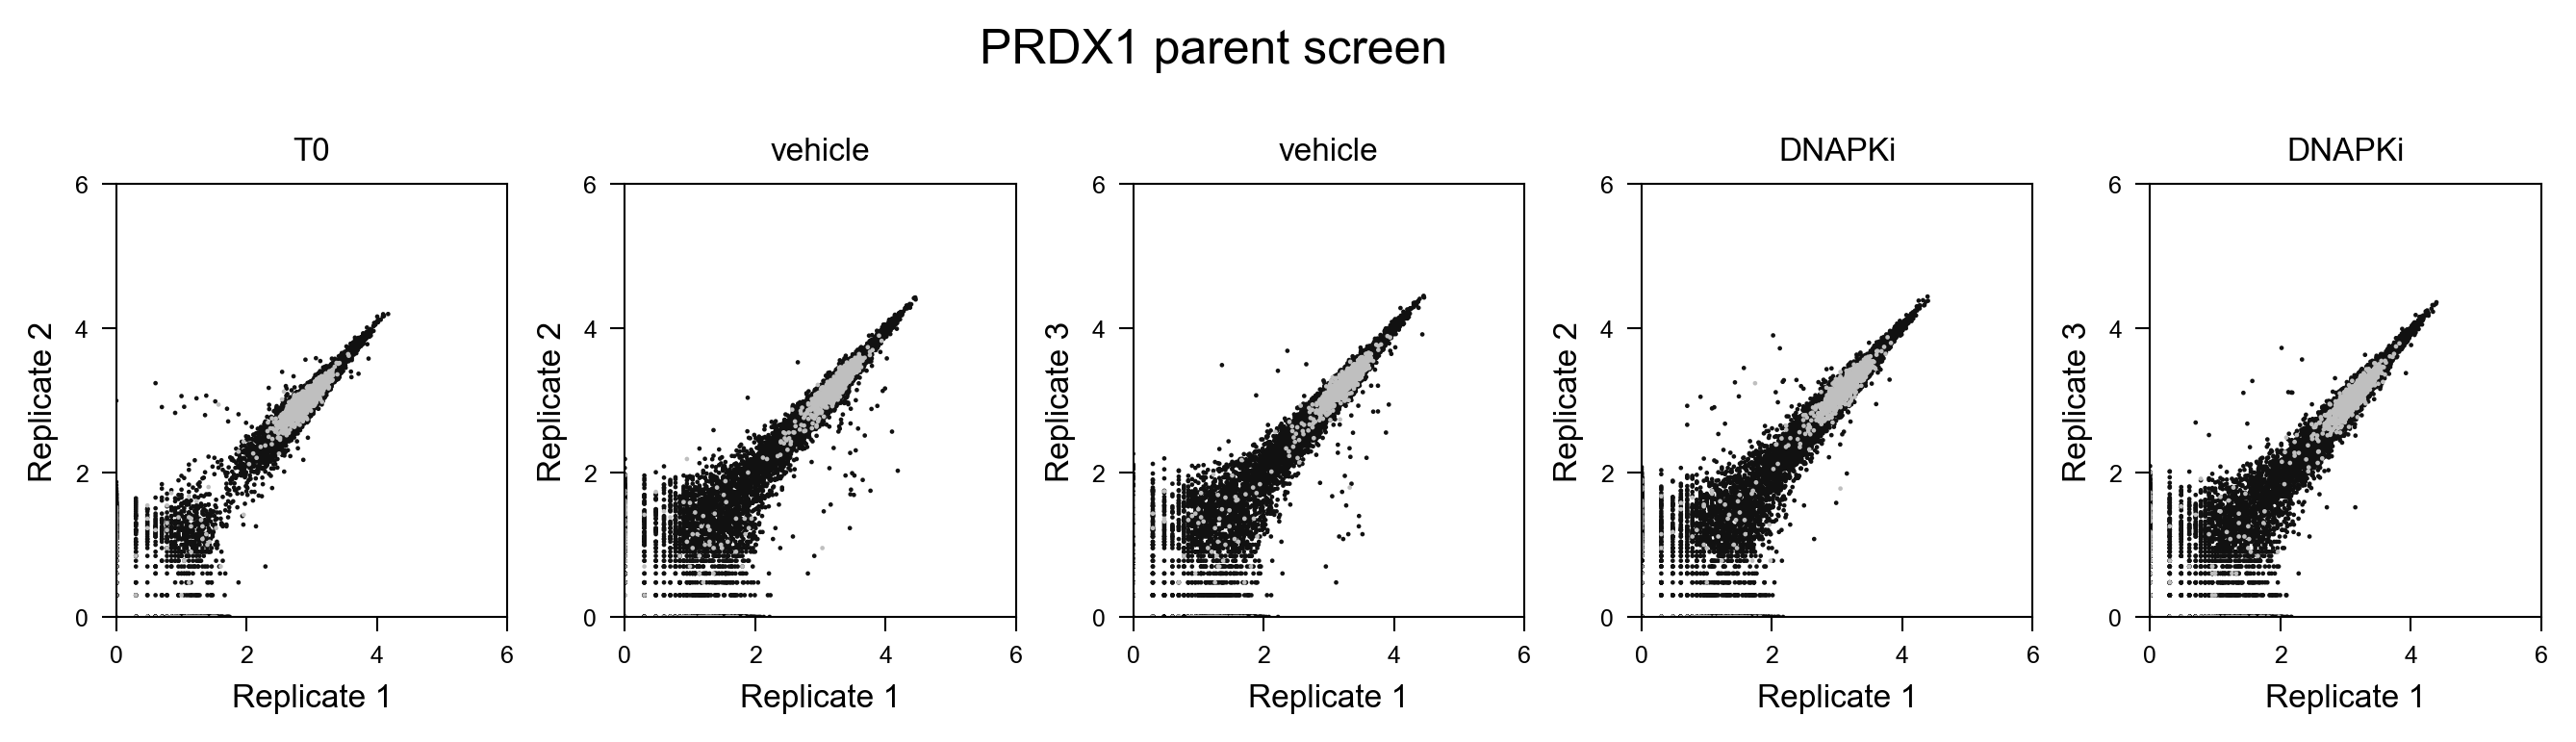

In [9]:
fig1, axes = plt.subplots(ncols=5,
                         figsize=(10,3), 
                         gridspec_kw={'wspace': 0.3, 'left': 0.12,'top':.8,'bottom':.3}, 
                         # sharey=True
                        )
scp.viz.plotReplicateScatter(axes[0], adata, 'i01','i02','T0',min_val=0,max_val=6, log_transform=True)
scp.viz.plotReplicateScatter(axes[1], adata, 'i03','i04','vehicle',min_val=0,max_val=6, log_transform=True)
scp.viz.plotReplicateScatter(axes[2], adata, 'i03','i05','vehicle',min_val=0,max_val=6, log_transform=True)
scp.viz.plotReplicateScatter(axes[3], adata, 'i06','i07','DNAPKi',min_val=0,max_val=6, log_transform=True)
scp.viz.plotReplicateScatter(axes[4], adata, 'i06','i08','DNAPKi',min_val=0,max_val=6, log_transform=True)

for ax in axes: 
    ax.tick_params(width=0.5)
    for i in ax.spines.values(): i.set_linewidth(0.5)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(8)
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(6)

fig1.suptitle('PRDX1 parent screen',fontsize=12)

plt.show()

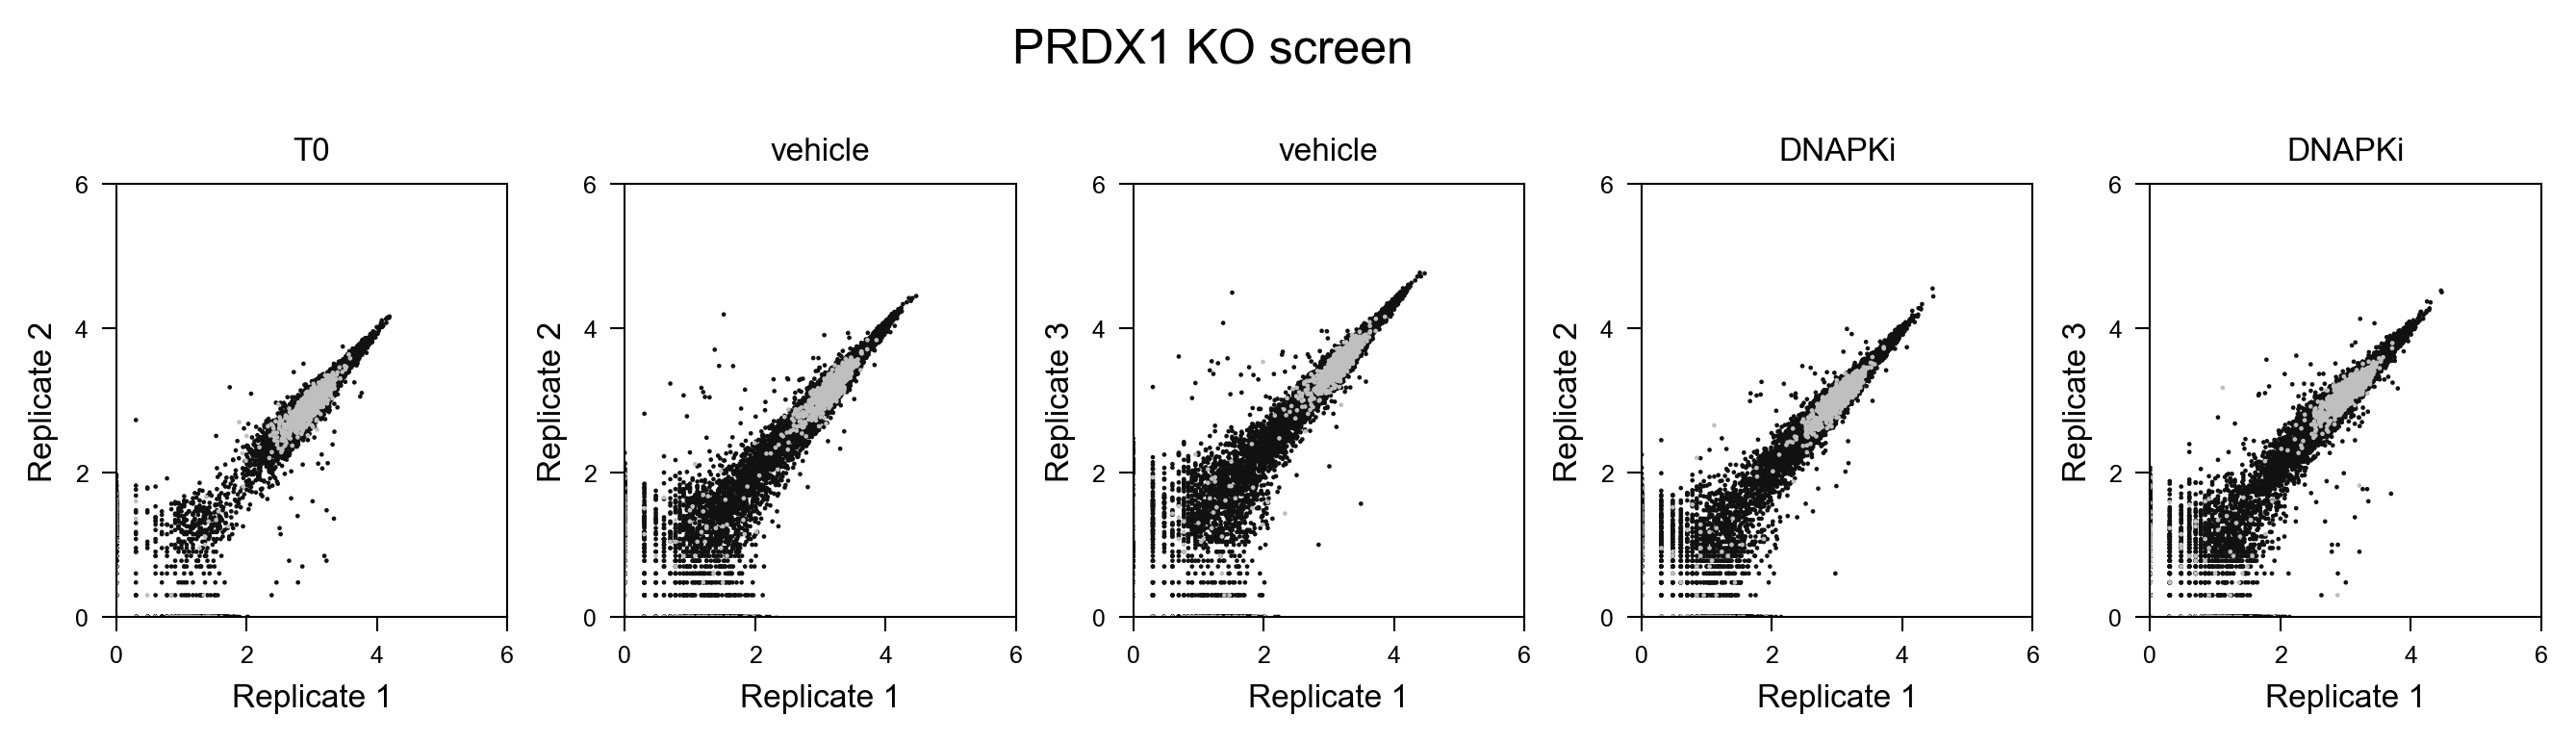

In [10]:
fig2, axes = plt.subplots(ncols=5,
                         figsize=(10,3), 
                         gridspec_kw={'wspace': 0.3, 'left': 0.12,'top':.8,'bottom':.3}, 
                         # sharey=True
                        )
scp.viz.plotReplicateScatter(axes[0], adata, 'i09','i10','T0',min_val=0,max_val=6, log_transform=True)
scp.viz.plotReplicateScatter(axes[1], adata, 'i11','i12','vehicle',min_val=0,max_val=6, log_transform=True)
scp.viz.plotReplicateScatter(axes[2], adata, 'i11','i13','vehicle',min_val=0,max_val=6, log_transform=True)
scp.viz.plotReplicateScatter(axes[3], adata, 'i14','i15','DNAPKi',min_val=0,max_val=6, log_transform=True)
scp.viz.plotReplicateScatter(axes[4], adata, 'i14','i16','DNAPKi',min_val=0,max_val=6, log_transform=True)

for ax in axes: 
    ax.tick_params(width=0.5)
    for i in ax.spines.values(): i.set_linewidth(0.5)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(8)
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(6)

fig2.suptitle('PRDX1 KO screen',fontsize=12)

plt.show()

#### Add 3rd pseudoreplicate for T0

In [11]:
# add a 3rd replicate to the parent data as average of the two existing replicates
def add_pseudoreplicate(adata,index_rep1,index_rep2, name_new_replicate=3):
    adata = adata.copy()
    # name index ad pseudoreplicate
    index_pseudorep = f'{index_rep1}_{index_rep2}'
    
    if index_pseudorep in adata.obs.index:
        raise ValueError(f'Pseudoreplicate {index_pseudorep} already exists in the AnnData object.')

    # create a new AnnData object
    adata_pseudorep = ad.AnnData(pd.Series(
        adata[adata.obs.index.isin([index_rep1,index_rep2])].X.mean(axis=0),
        index=adata.var.index,
        name=index_pseudorep
    ).astype(int).to_frame().T)
    # update the metadata
    adata_pseudorep.obs['replicate'] = name_new_replicate
    for key in adata.obs.columns:
        if key not in adata_pseudorep.obs.columns:
            adata_pseudorep.obs[key] = adata.obs[key].loc[index_rep1]

    # add the pseudoreplicate to the original AnnData object
    out = ad.concat([adata, adata_pseudorep])
    out.var = adata.var.copy()

    return out

In [12]:
adata = add_pseudoreplicate(adata,'i01','i02')

In [13]:
adata = add_pseudoreplicate(adata,'i09','i10')

In [14]:
adata.obs

cell line timepoint condition  replicate pop doublings  pop_doublings
i01        parent        T0        T0          1             -            NaN
i02        parent        T0        T0          2             -            NaN
i03        parent      Tend   vehicle          1      8.099107       8.099107
i04        parent      Tend   vehicle          2      7.760087       7.760087
i05        parent      Tend   vehicle          3      7.799925       7.799925
i06        parent      Tend    DNAPKi          1      7.459794       7.459794
i07        parent      Tend    DNAPKi          2      7.541174       7.541174
i08        parent      Tend    DNAPKi          3      7.709747       7.709747
i09       PRDX1KO        T0        T0          1             -            NaN
i10       PRDX1KO        T0        T0          2             -            NaN
i11       PRDX1KO      Tend   vehicle          1       6.93964       6.939640
i12       PRDX1KO      Tend   vehicle          2      7.325594       7.325594
i13       PRDX1KO      Tend   vehicle          3      7.048209       7.048209
i14       PRDX1KO      Tend    DNAPKi          1       1.94945       1.949450
i15       PRDX1KO      Tend    DNAPKi          2      2.113679       2.113679
i16       PRDX1KO      Tend    DNAPKi          3      2.469331       2.469331
i01_i02    parent        T0        T0          3             -            NaN
i09_i10   PRDX1KO        T0        T0          3             -            NaN

# Step 2: Phenotype calculation

- [x] 'PRDX1_parent gamma vehicle_vs_T0'
- [x] 'PRDX1_parent rho DNAPKi_vs_vehicle',
- [x] 'PRDX1_parent tau DNAPKi_vs_T0',

- [x] 'PRDX1_KO gamma vehicle_vs_T0',
- [x] 'PRDX1_KO rho DNAPKi_vs_vehicle',
- [x] 'PRDX1_KO tau DNAPKi_vs_T0',

- [x] 'vehicle_PRDX1KO_vs_vehicle_parent'

In [15]:
adata_PRDX1KO = adata[adata.obs['cell line'].eq('PRDX1KO')].copy()
adata_parent  = adata[adata.obs['cell line'].eq('parent')].copy()

In [16]:
adata_vehicle = adata[adata.obs['condition'].isin(['T0','vehicle'])].copy()
adata_vehicle = adata_vehicle[~(adata_vehicle.obs['cell line'].eq('PRDX1KO')&adata_vehicle.obs['condition'].eq('T0'))].copy()
adata_vehicle.obs['condition_original'] = adata_vehicle.obs['condition']
adata_vehicle.obs.loc[adata_vehicle.obs['cell line'].eq('PRDX1KO'),'condition'] = 'PRDX1KO'
adata_vehicle.obs.loc[adata_vehicle.obs['condition'].eq('vehicle'),'condition'] = 'parent'

In [17]:
adata_vehicle.obs

cell line timepoint condition  replicate pop doublings  pop_doublings  \
i01        parent        T0        T0          1             -            NaN   
i02        parent        T0        T0          2             -            NaN   
i03        parent      Tend    parent          1      8.099107       8.099107   
i04        parent      Tend    parent          2      7.760087       7.760087   
i05        parent      Tend    parent          3      7.799925       7.799925   
i11       PRDX1KO      Tend   PRDX1KO          1       6.93964       6.939640   
i12       PRDX1KO      Tend   PRDX1KO          2      7.325594       7.325594   
i13       PRDX1KO      Tend   PRDX1KO          3      7.048209       7.048209   
i01_i02    parent        T0        T0          3             -            NaN   

        condition_original  
i01                     T0  
i02                     T0  
i03                vehicle  
i04                vehicle  
i05                vehicle  
i11                vehicle  
i12                vehicle  
i13                vehicle  
i01_i02                 T0

In [18]:
def run_pipeline(adata, untreated='vehicle', treated='DNAPKi'):
    
    screen = scp.PooledScreens(adata, verbose=True)
    
    screen.filterLowCounts()
    
    screen.countNormalization()
    
    screen.calculateDrugScreen(
        t0='T0', untreated=untreated, treated=treated, score_level='compare_reps',
    )

    return screen


def plot_score_scatters(screen, title):
    fig, axes = plt.subplots(ncols=2,
                             figsize=(4.2,3), 
                             gridspec_kw={'wspace': 0.4, 'left': 0.12,'top':.8,'bottom':.3}, 
                             # sharey=True
                            )
    scp.viz.plotReplicateScatter(axes[0], screen.pdata, 'gamma_replicate_1','gamma_replicate_2','gamma',
                                 # min_val=-1,max_val=1,
                                 log_transform=False)
    scp.viz.plotReplicateScatter(axes[1], screen.pdata, 'tau_replicate_1','tau_replicate_2','tau',
                                 # min_val=-1,max_val=1,
                                 log_transform=False)
    
    
    for ax in axes: 
        ax.tick_params(width=0.5)
        for i in ax.spines.values(): i.set_linewidth(0.5)
        # ax.spines['top'].set_visible(False)
        # ax.spines['right'].set_visible(False)
        # ax.spines['bottom'].set_visible(False)
        # ax.spines['left'].set_visible(False)
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
            item.set_fontsize(8)
        for item in ax.get_xticklabels() + ax.get_yticklabels():
            item.set_fontsize(6)
        
        # ax.set_xticks(list(map(lambda x: x/10.0, range(-10, 11, 5))))
        # ax.set_xticks(list(map(lambda x: x/10.0, range(-10, 11, 5))))
    
    fig.suptitle(title,fontsize=12)
    
    return fig


def plot_count_norm(screen, title):
    fig,axes = plt.subplots(1,2,sharey=True,figsize=(4.2,3))
    
    # plot count distribution
    np.log10(
        screen.adata.to_df(layer='raw_counts').T+1
    ).plot.hist(bins=100, histtype='step', ax=axes[0])
    
    # plot count distribution
    np.log10(
        screen.adata.to_df().T+1
    ).plot.hist(bins=100, histtype='step', ax=axes[1])
    
    for ax in axes: 
        ax.set_xlabel('log10(counts+1)')
        ax.get_legend().remove()
        ax.grid(False)
        ax.tick_params(width=0.5)
        for i in ax.spines.values(): i.set_linewidth(0.5)
        # ax.spines['top'].set_visible(False)
        # ax.spines['right'].set_visible(False)
        # ax.spines['bottom'].set_visible(False)
        # ax.spines['left'].set_visible(False)
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
            item.set_fontsize(8)
        for item in ax.get_xticklabels() + ax.get_yticklabels():
            item.set_fontsize(6)
        ax.set_yticks(range(0, 1201, 500))
        
    fig.suptitle(f'{title}\n\nSequencing depth normalization',fontsize=12,horizontalalignment='center',y=0.9)

    fig.tight_layout(
        h_pad=1, w_pad=.4,
        # rect=[0, 0.03, 1, 0.99]
    )

    return fig


def plot_volcanos(screen, title, untreated='vehicle', treated='DNAPKi', score_names=['gamma','tau','rho']):
    plotter = scp.viz.DrugScreenPlotter(
        screen,
        untreated=untreated,
        treated=treated,
        threshold  =  1
    )

    gamma, tau, rho = plotter._prep_data(pvalue_col='ttest pvalue')
    
    # Volcano plot for rho score
    fig, axes = plt.subplots(1,3, figsize=(6, 3), dpi = 300)
    
    if 'gamma' in score_names:
        plotter.drawVolcanoGamma(
            axes[0],
            gamma_df=gamma,
            pvalue_col='ttest pvalue',
            dot_size=.1,
            # ylims=(0,5)
        )
    else:
        axes[0].set_visible(False)

    if 'tau' in score_names:
        plotter.drawVolcanoTau(
            axes[1],
            tau_df=tau,
            pvalue_col='ttest pvalue',
            dot_size=.1,
            # ylims=(0,5)
        )
    else:
        axes[1].set_visible(False)
    
    if 'rho' in score_names:
        plotter.drawVolcanoRho(
            axes[2],
            rho_df=rho,
            pvalue_col='ttest pvalue',
            dot_size=.1,
            # ylims=(0,5)
        )
    else:
        axes[2].set_visible(False)

    for ax in axes:
        if ax.get_visible():
            ax.get_legend().remove()
            ax.grid(False)
            ax.tick_params(width=0.5)
            for i in ax.spines.values(): i.set_linewidth(0.5)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # ax.spines['bottom'].set_visible(False)
            # ax.spines['left'].set_visible(False)
            for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
                item.set_fontsize(8)
            for item in ax.get_xticklabels() + ax.get_yticklabels():
                item.set_fontsize(6)
    
    fig.suptitle(title, fontsize=12,horizontalalignment='center',y=0.9)
    fig.tight_layout(
        h_pad=1, w_pad=.4,
        # rect=[0, 0.03, 1, 0.99]
    ) # left, bottom, right, top

    return fig

### PRDX1 parent screen

In [19]:
screen_parent = run_pipeline(adata_parent)

44418 variables with less than 50 reads (filter_type: 'all')
Pseudocount added to counts.
Counts normalized by sequencing depth.
	vehicle vs T0
	DNAPKi vs T0
	DNAPKi vs vehicle


#### replicate level scores

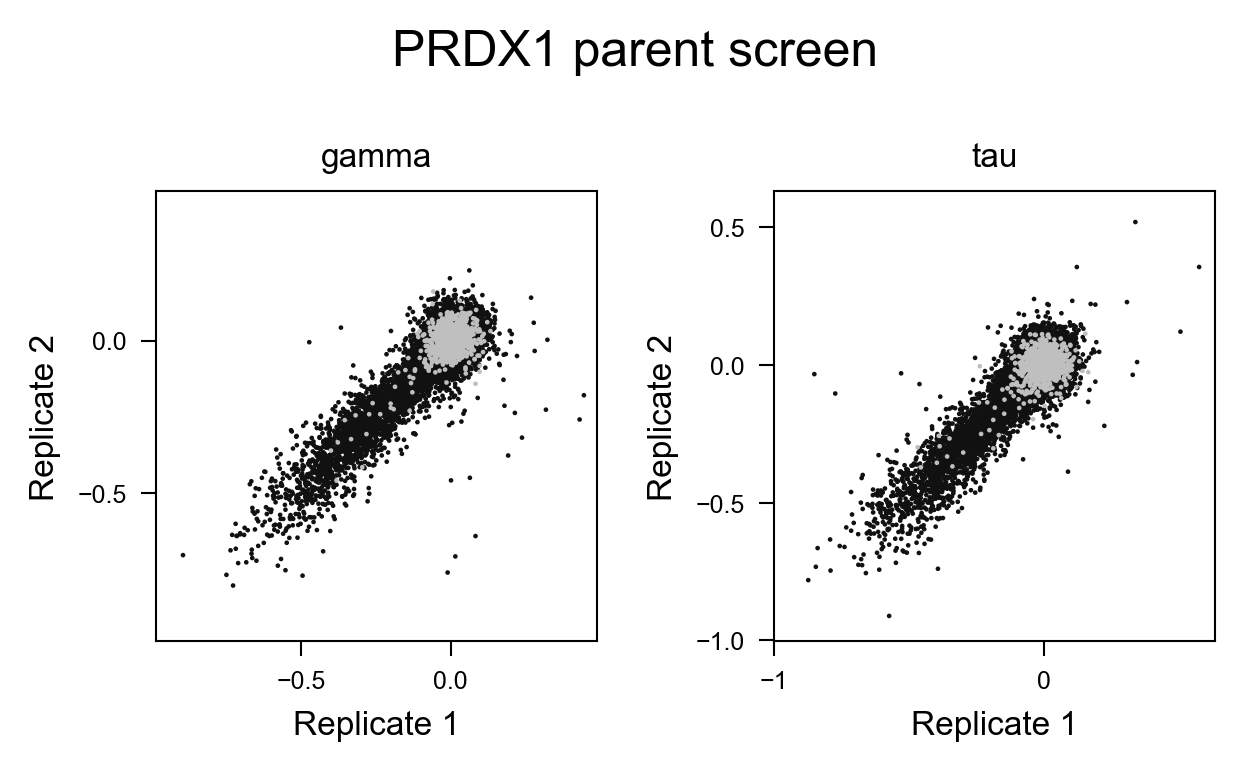

In [20]:
fig3 = plot_score_scatters(
    screen_parent, 
    title='PRDX1 parent screen'
)

#### count norm

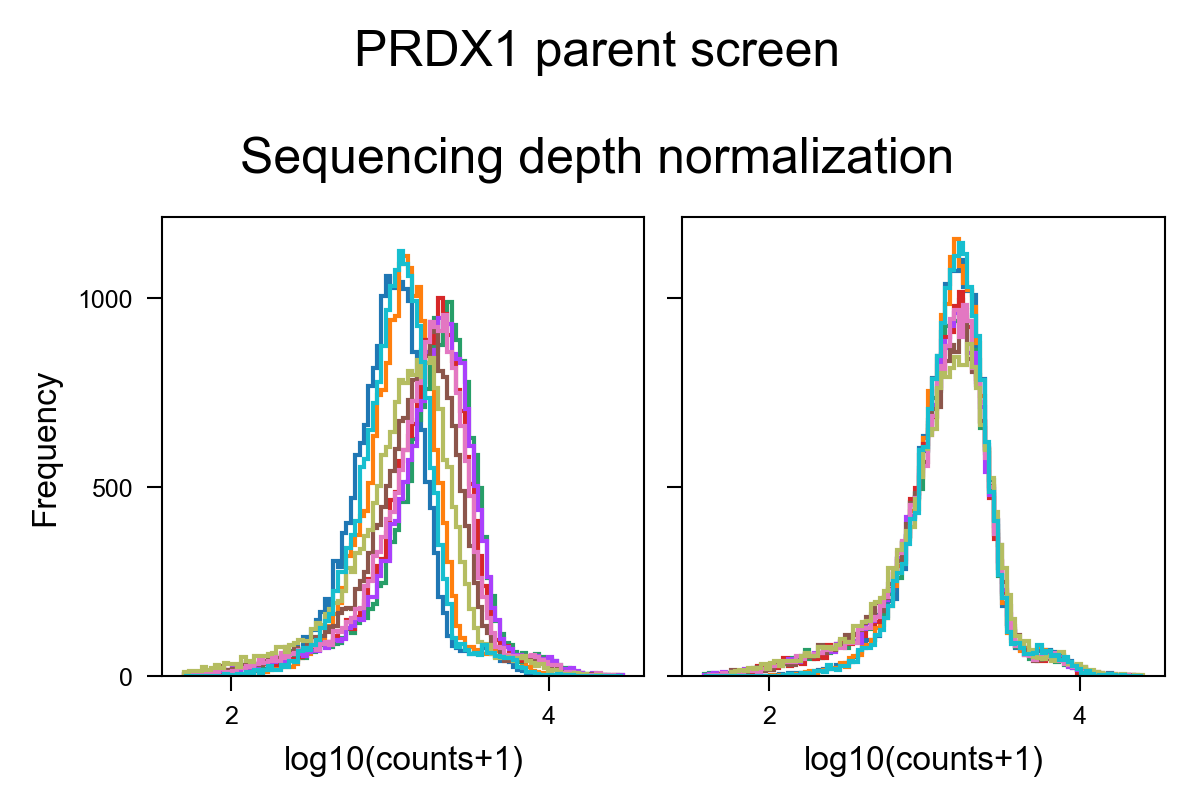

In [21]:
fig4 = plot_count_norm(screen_parent, title='PRDX1 parent screen')

#### volcano plots

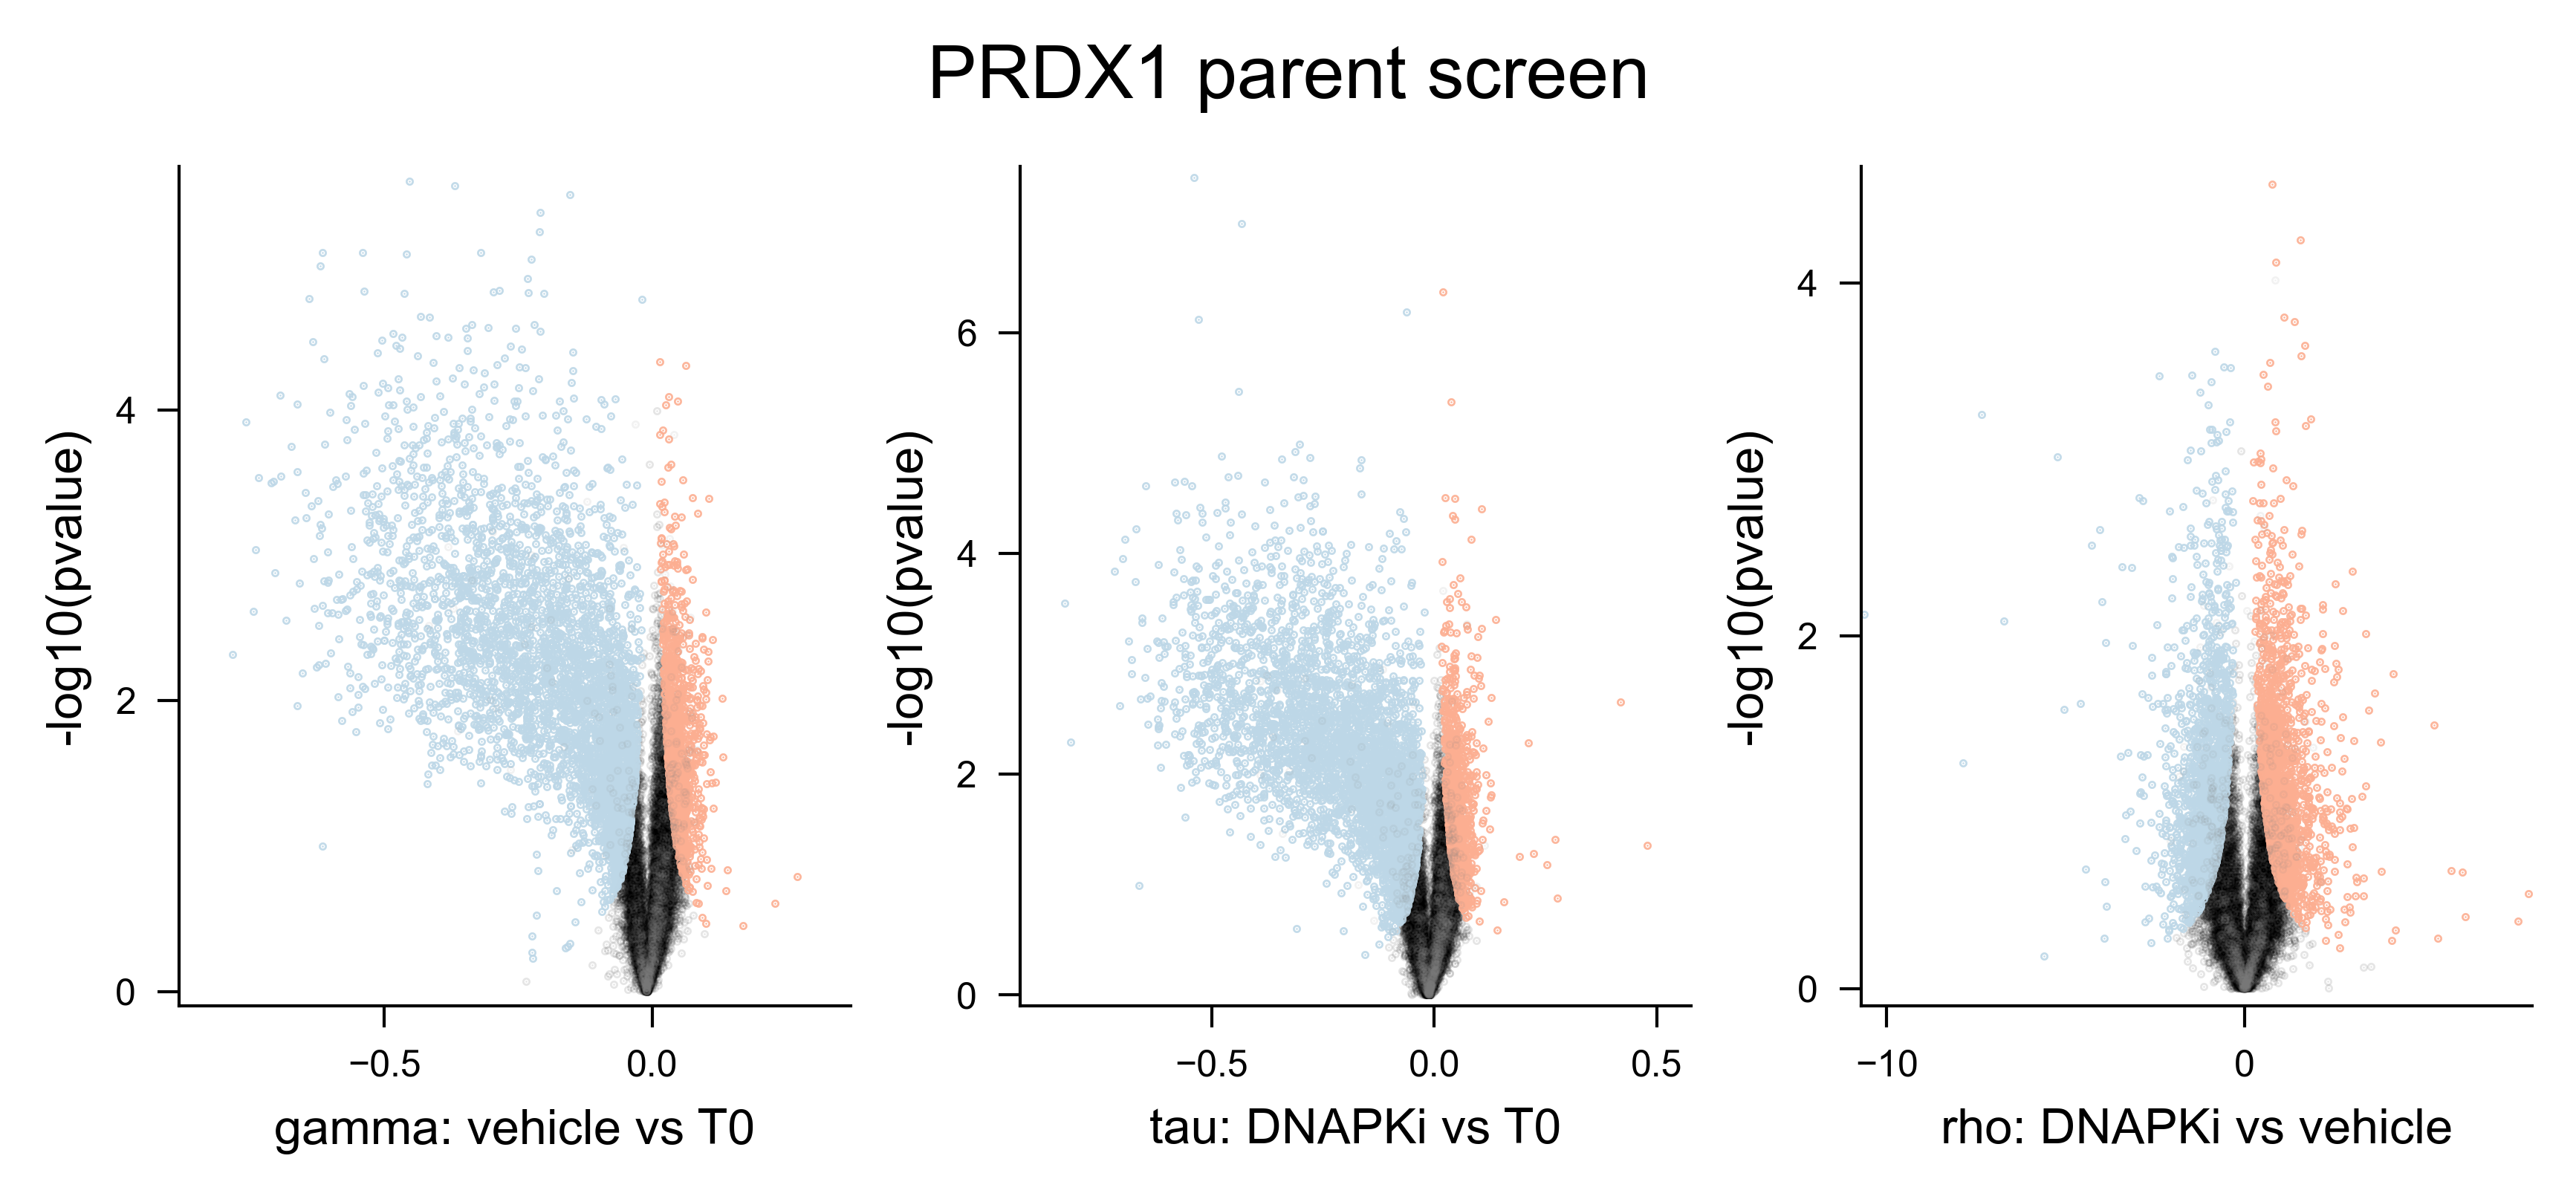

In [22]:
fig5 = plot_volcanos(screen_parent, title='PRDX1 parent screen')

/home/abea/miniconda3/envs/screenpro2/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


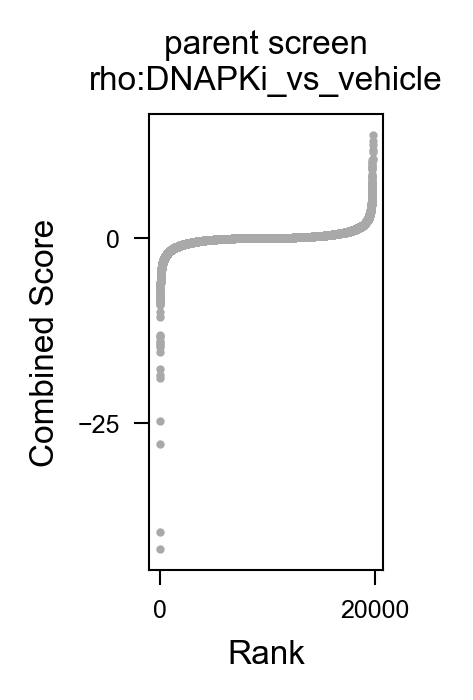

In [23]:
rho = screen_parent.getPhenotypeScores('rho:DNAPKi_vs_vehicle',10)


fig, ax = plt.subplots(figsize=(1, 2))

scp.viz.rankPlot(rho, 'combined_score', ax=ax, dot_size=1, ylabel='Combined Score', title='parent screen\nrho:DNAPKi_vs_vehicle')

ax.grid(False)
ax.tick_params(width=0.5)
for i in ax.spines.values(): i.set_linewidth(0.5)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(8)
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(6)

# plt.savefig('rank_plot.pdf')
plt.show()

### PRDX1 KO screen

In [24]:
screen_PRDX1KO = run_pipeline(adata_PRDX1KO)


43922 variables with less than 50 reads (filter_type: 'all')
Pseudocount added to counts.
Counts normalized by sequencing depth.
	vehicle vs T0
	DNAPKi vs T0
	DNAPKi vs vehicle


#### replicate level scores

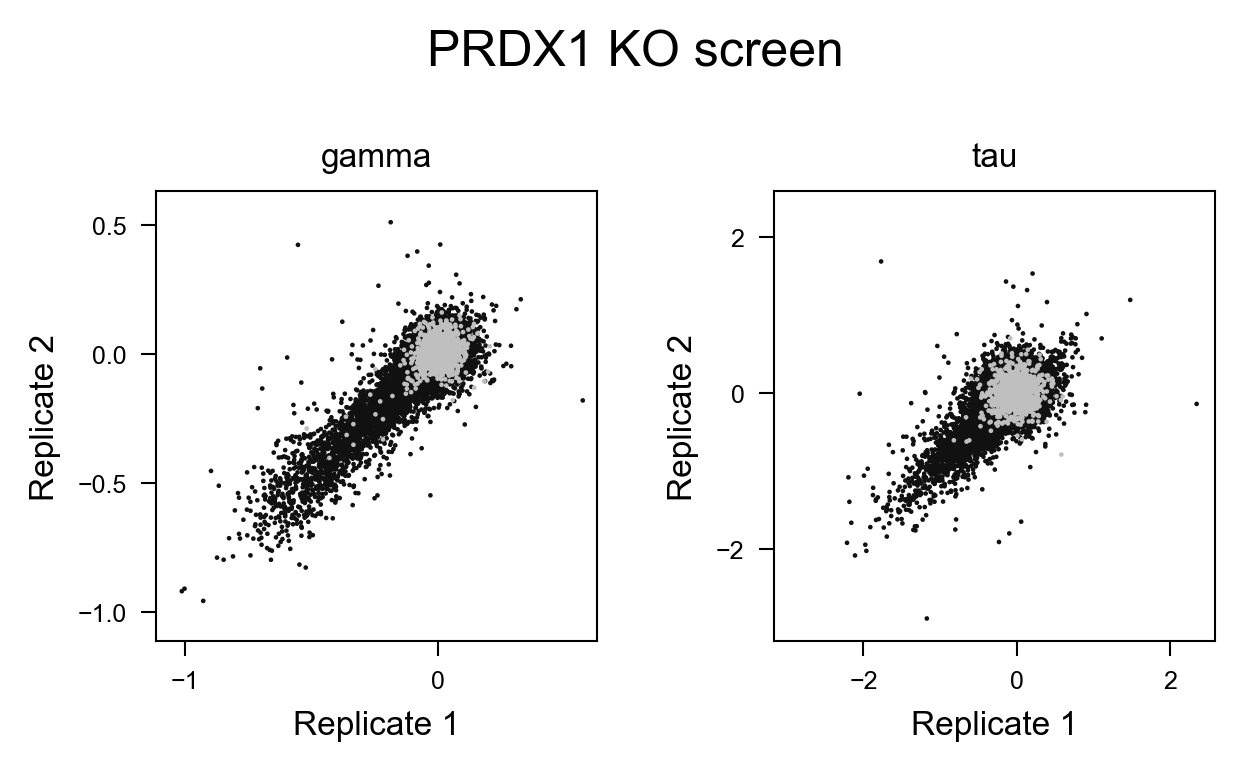

In [25]:
fig6 = plot_score_scatters(
    screen_PRDX1KO, 
    title='PRDX1 KO screen'
)

#### count norm

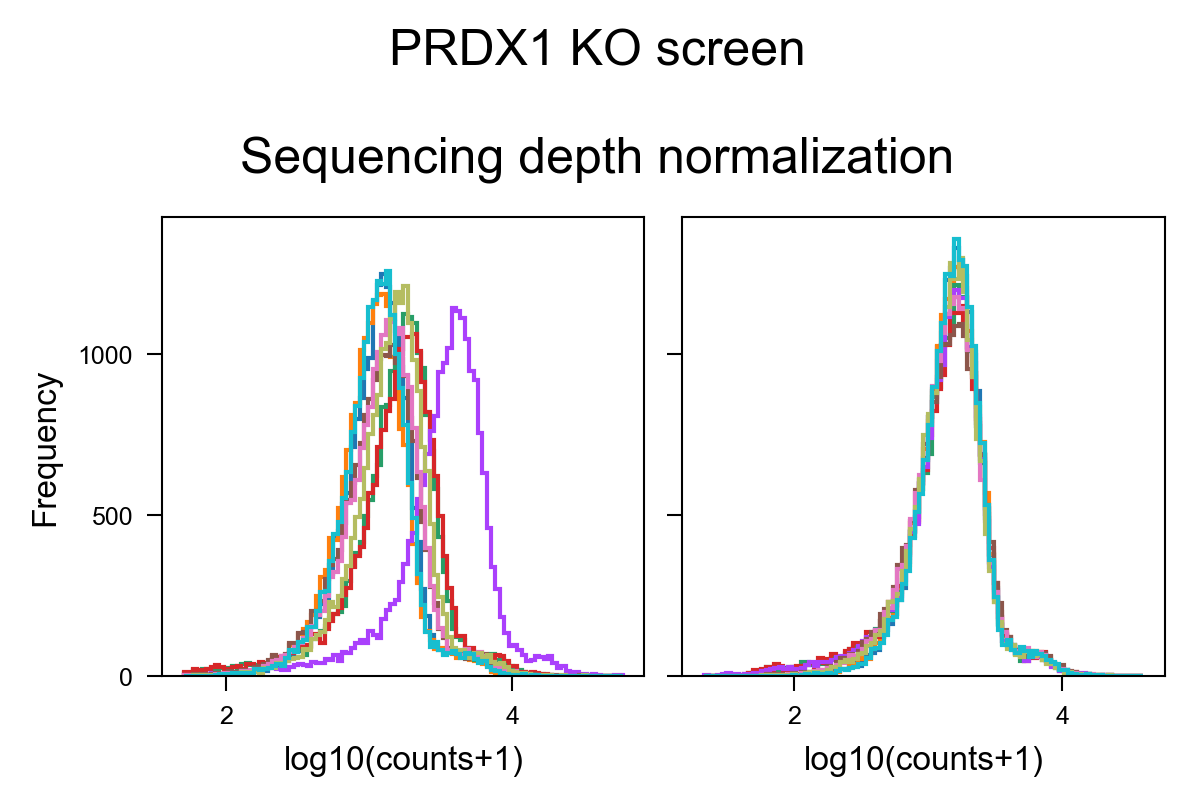

In [26]:
fig7 = plot_count_norm(screen_PRDX1KO, title='PRDX1 KO screen')

#### volcano plots

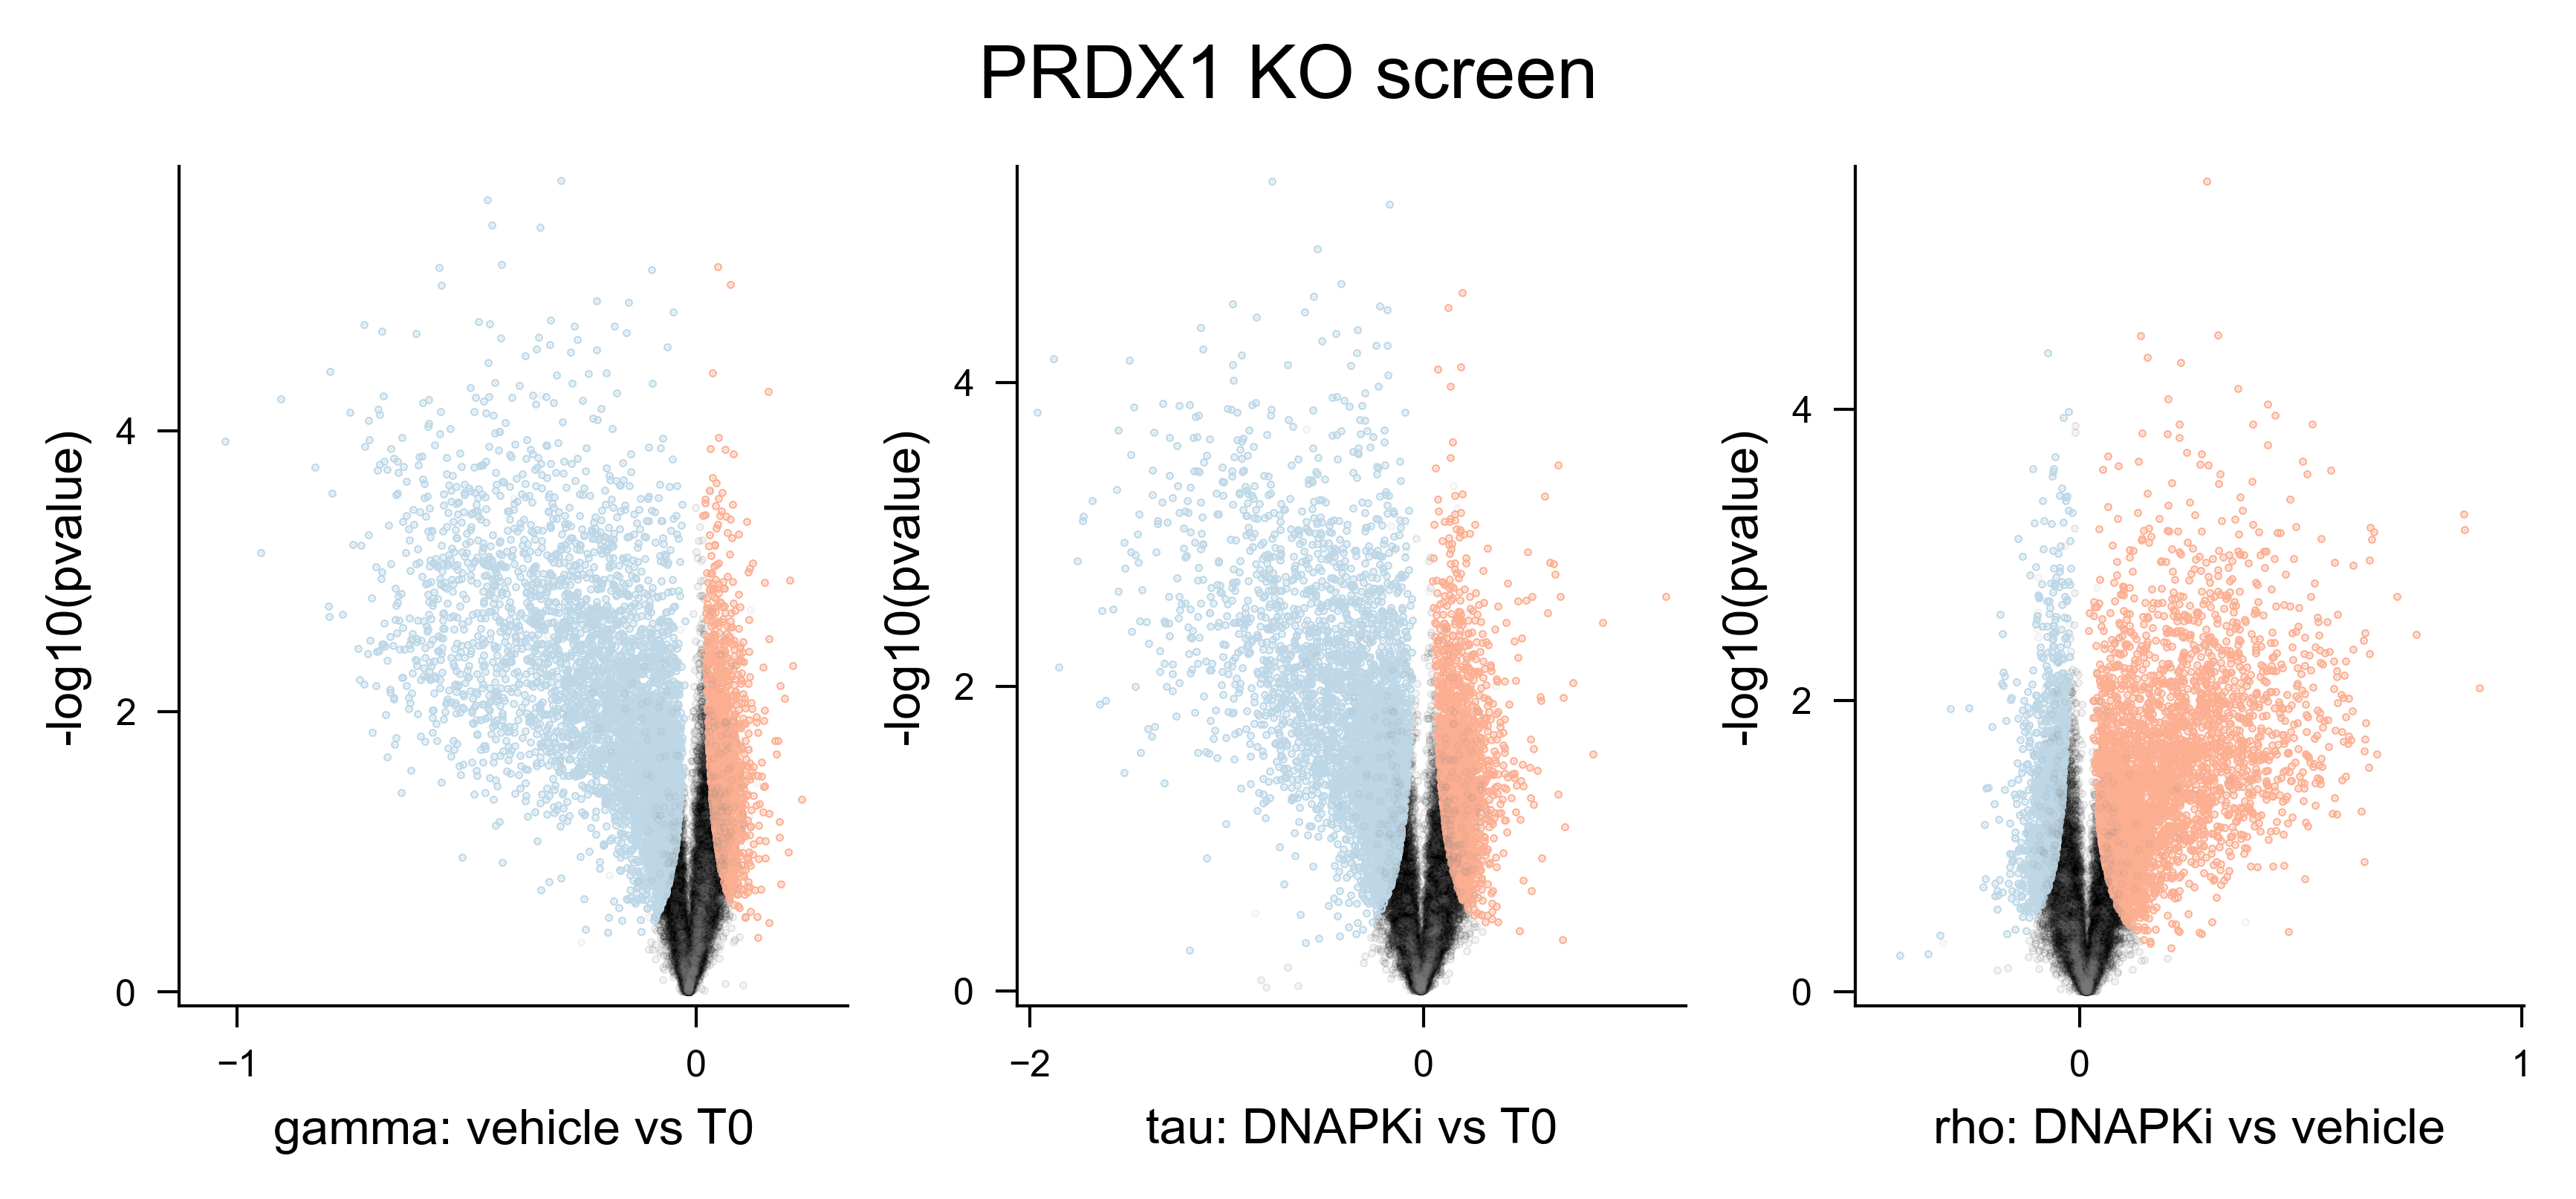

In [27]:
fig8 = plot_volcanos(screen_PRDX1KO, title='PRDX1 KO screen')

### adata_vehicle

In [28]:
screen_vehicle = run_pipeline(adata_vehicle, untreated='parent', treated='PRDX1KO')

44315 variables with less than 50 reads (filter_type: 'all')
Pseudocount added to counts.
Counts normalized by sequencing depth.
	parent vs T0
	PRDX1KO vs T0
	PRDX1KO vs parent


#### replicate level scores

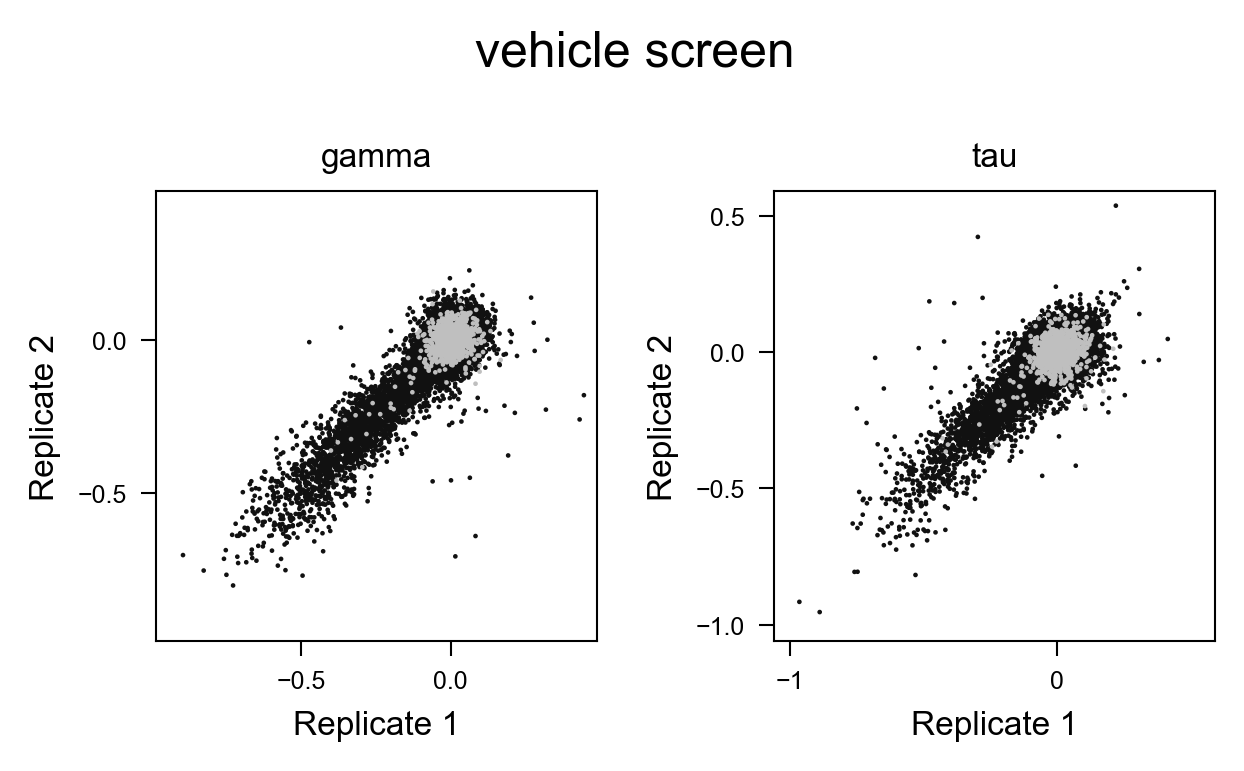

In [29]:
fig9 = plot_score_scatters(
    screen_vehicle, 
    title='vehicle screen'
)

#### count norm

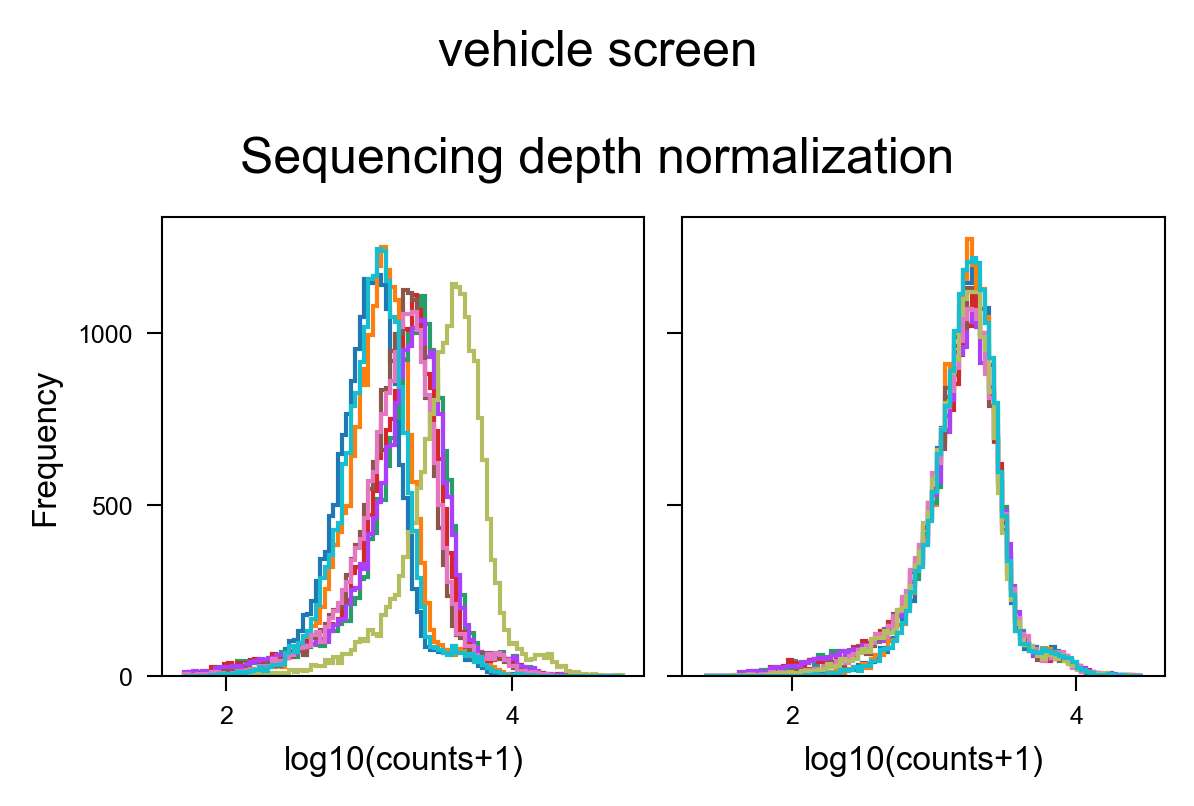

In [30]:
fig10 = plot_count_norm(screen_vehicle, title='vehicle screen')

#### volcano plots

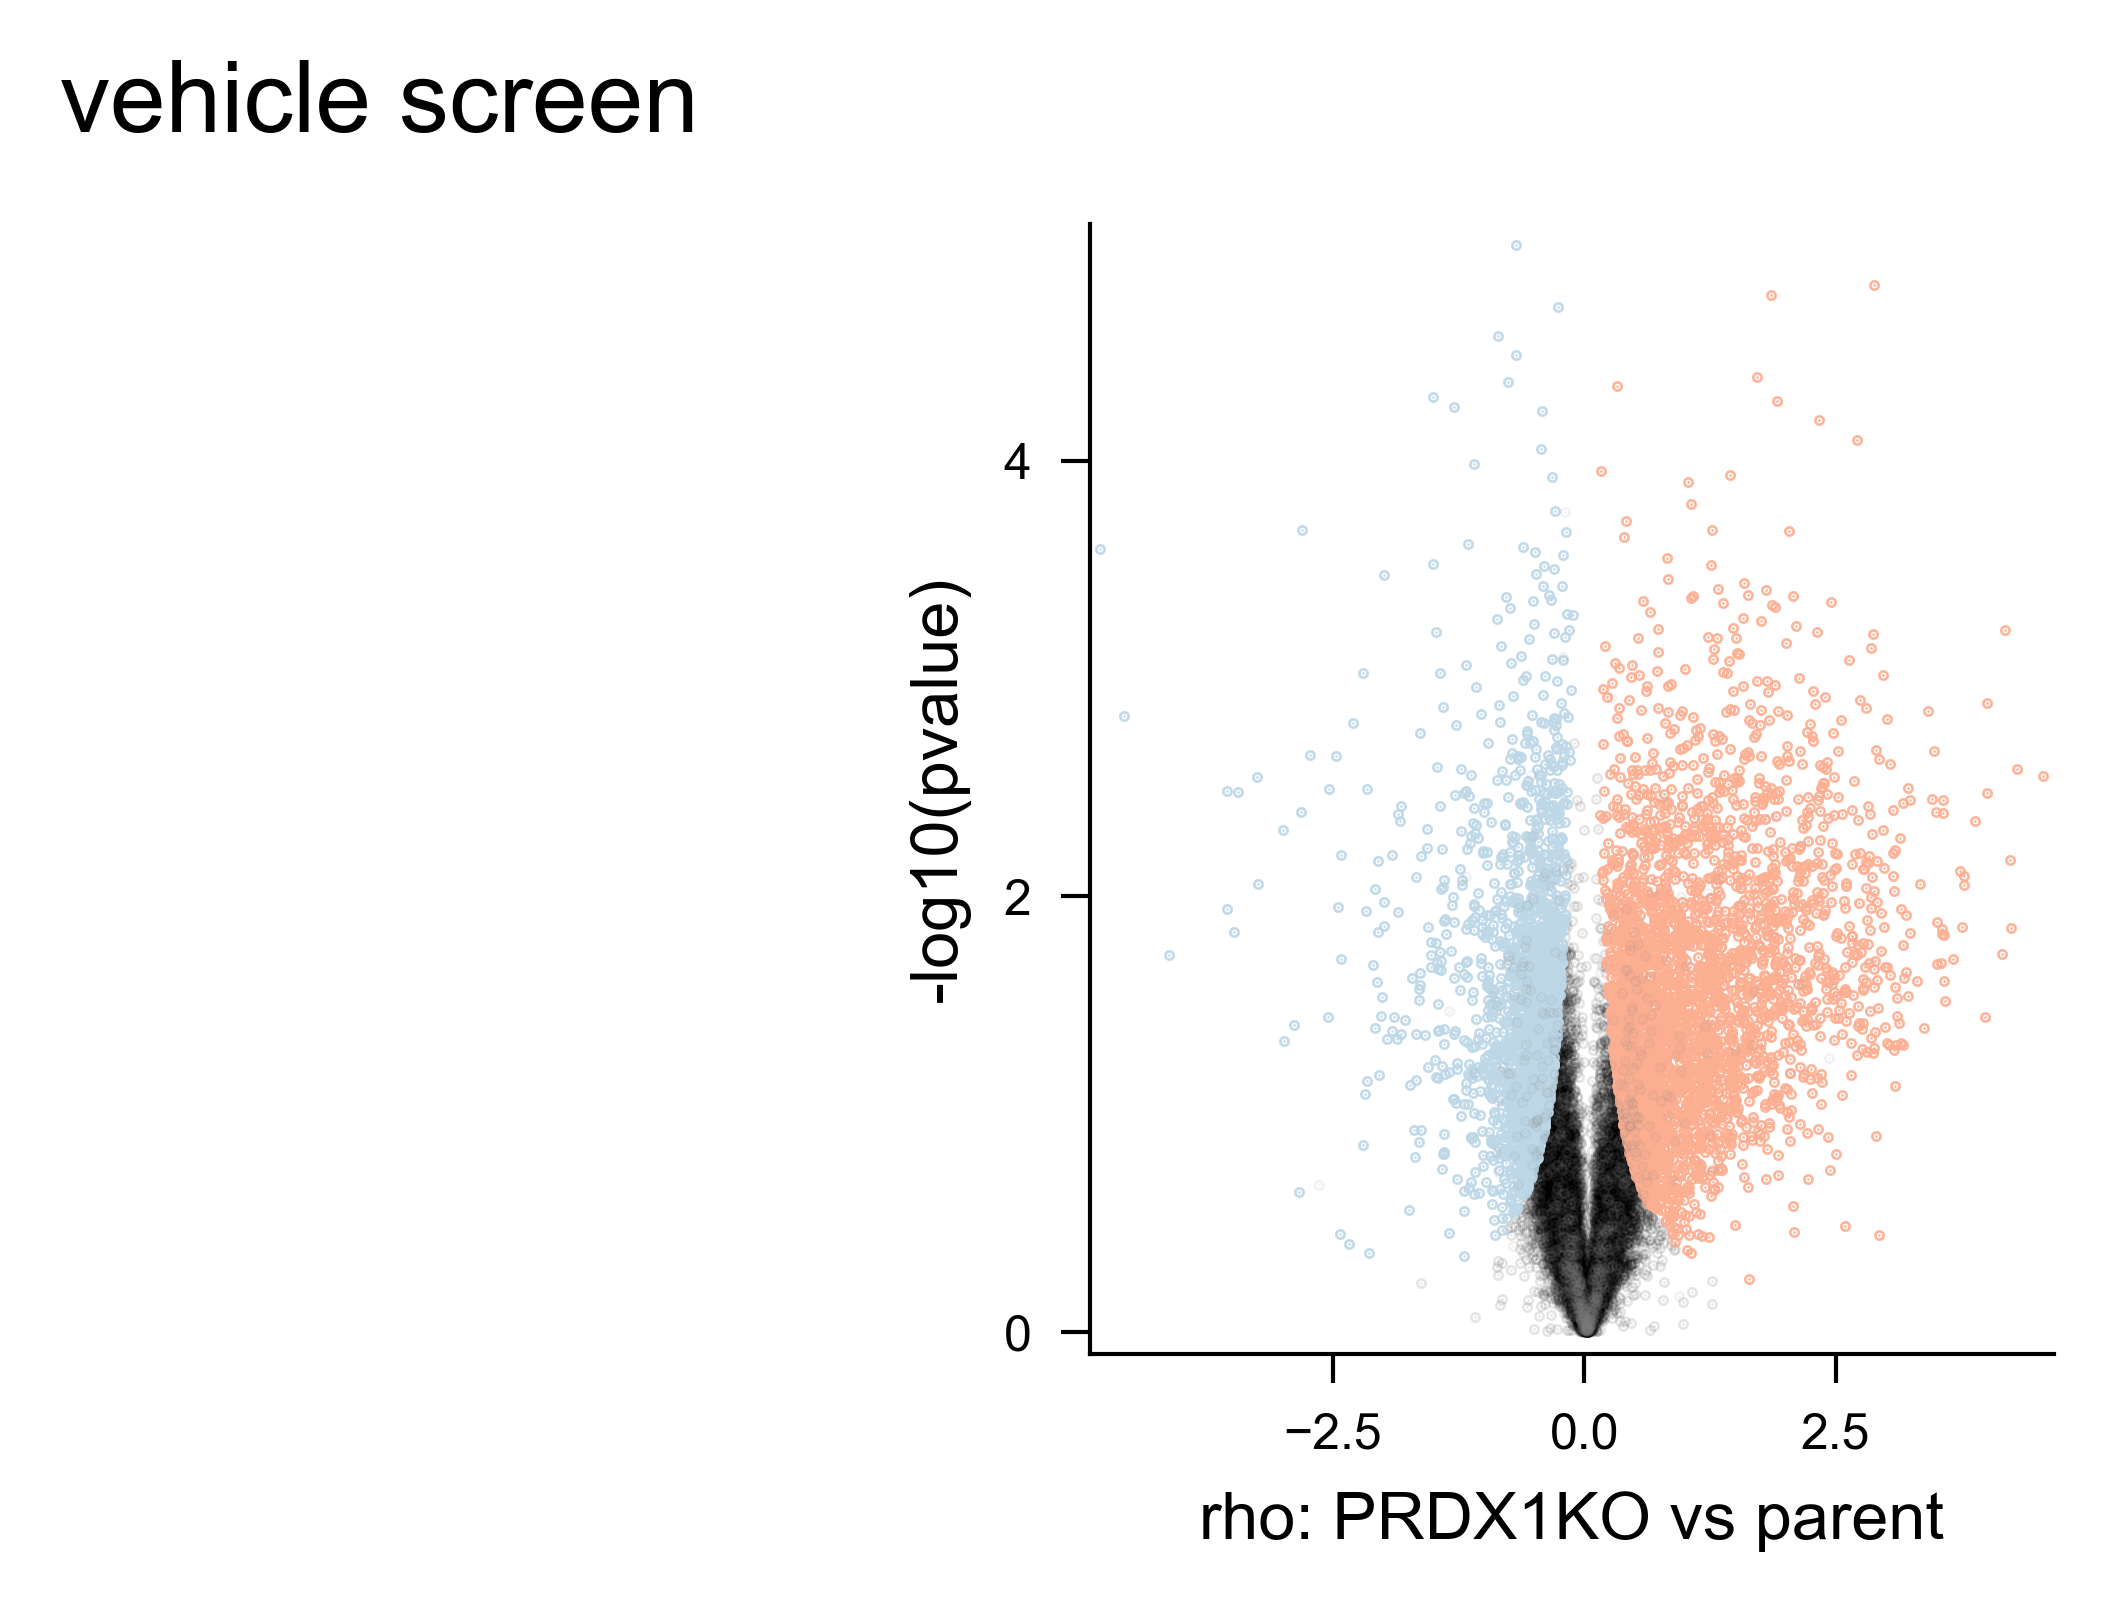

In [31]:
fig11 = plot_volcanos(screen_vehicle, untreated='parent', treated='PRDX1KO', title='vehicle screen', score_names=['rho'])

# 

In [32]:
screen_parent.getAnnotatedTable(threshold=2)['rho:DNAPKi_vs_vehicle'].groupby('label').size()

label
sensitivity_hit       737
resistance_hit        680
negative_control     1018
target_non_hit      17384
dtype: int64

In [33]:
screen_PRDX1KO.getAnnotatedTable(threshold=2)['rho:DNAPKi_vs_vehicle'].groupby('label').size()

label
sensitivity_hit       408
resistance_hit       2546
negative_control     1020
target_non_hit      16341
dtype: int64

In [34]:
screen_vehicle.getAnnotatedTable(threshold=2)['rho:PRDX1KO_vs_parent'].groupby('label').size()

label
sensitivity_hit       818
resistance_hit       2260
negative_control     1019
target_non_hit      15825
dtype: int64

### save to file

In [35]:
screen = scp.PooledScreens(adata, verbose=True)

screen.countNormalization()

Pseudocount added to counts.
Counts normalized by sequencing depth.


In [36]:
screen.adata

AnnData object with n_obs × n_vars = 18 × 64237
    obs: 'cell line', 'timepoint', 'condition', 'replicate', 'pop doublings', 'pop_doublings', 'size_factors'
    var: 'sgID_A', 'sgID_B', 'target_A', 'protospacer_A', 'target_B', 'protospacer_B', 'targetType', 'target', 'sequence'
    layers: 'raw_counts', 'seq_depth_norm'

In [ ]:
with pd.ExcelWriter('CRISPRi-PRDX1-DDRi-screens.xlsx', engine='openpyxl') as writer:
    screen.adata.obs.to_excel(writer, sheet_name='sample sheet')
    screen.adata.to_df(layer='raw_counts').astype(int).T.to_excel(writer, sheet_name='raw counts')
    screen.adata.to_df(layer='seq_depth_norm').astype(int).T.to_excel(writer, sheet_name='normalized counts')
    screen_parent.getAnnotatedTable(threshold=2).to_excel(writer, sheet_name='parent screen')
    screen_PRDX1KO.getAnnotatedTable(threshold=2).to_excel(writer, sheet_name='PRDX1KO screen')
    screen_vehicle.getAnnotatedTable(threshold=2)[['rho:PRDX1KO_vs_parent']].to_excel(writer, sheet_name='vehicle screen')

In [ ]:
import datetime
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('CRISPRi-PRDX1-DDRi-screens.pdf') as pdf:
    for fig in [fig1,fig2,fig3,fig4,fig5,fig6,fig7,fig8,fig9,fig10,fig11]:
        pdf.savefig(fig)  # saves the current figure into a pdf page

    d = pdf.infodict()
    d['Title'] = 'ScreenPro2 plots'
    d['ModDate'] = datetime.datetime.today()

#### 

In [37]:
# rho = screen_parent.phenotypes['compare_reps']['rho:DNAPKi_vs_vehicle']

# rho_ann = scp.ps.annotateScoreTable(
#     rho,'up','dn',10, pvalue_col='ttest pvalue',ctrl_label='negative_control'
# )

# rho_ann['rank'] = rho_ann.combined_score.rank().astype(int)



# genes = [
#     'MDM2', 'MDM4', 'TAF4', 'KIF18B', 'YTHDC1',
#     'INTS12', 'INTS10',
#     # 'INTS5', 'INTS6','C7orf26', 
#     # 'TOE1',
#     'VPS37A', 
#     # 'SOX9', 'ACTB','RNF4',
# ]
# # genes = rank_genes_to_df(dep_data,10000).head(30).names.to_list()

# scp.viz.rankPlot

# fig, ax = plt.subplots(figsize=(5, 5))

# scp.viz.rankPlot(rho_ann.combined_score,ax=ax)

# # ax.set_xlim((-2300,18200))

# ax.hlines(y=0.05,xmin=0,xmax=18200,linestyles='dashed',linewidth=.5, color='gray')
# ax.hlines(y=-0.05,xmin=-2300,xmax=18200,linestyles='dashed',linewidth=.5, color='gray')

# plt.tight_layout()
# # plt.savefig('rank_plot.pdf')
# plt.show()

# 

In [38]:
%reload_ext watermark

In [39]:
%watermark

Last updated: 2024-07-15T12:57:50.346847-07:00

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.15.0-107-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit



In [40]:
%watermark --iversions

scanpy    : 1.9.6
matplotlib: 3.6.3
screenpro : 0.4.5
anndata   : 0.10.7
pandas    : 2.1.4
numpy     : 1.26.4

